<a href="https://colab.research.google.com/github/shah-zeb-naveed/data-science-notes/blob/main/recommender_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q "numpy<2" "pandas>=2.2.3" "scikit-surprise>=1.1.4",

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 903.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 42.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# Data

In [ ]:
# 1. Simulate user-destination ride data
# Implicit feedback: more rides = stronger preference
data_dict = {
    'user_id': ['U1', 'U1', 'U1', 'U2', 'U2', 'U3', 'U3', 'U3', 'U3'],
    'destination_id': ['D1', 'D2', 'D3', 'D1', 'D4', 'D2', 'D3', 'D4', 'D5'],
    'ride_count': [10, 5, 2, 7, 3, 8, 1, 4, 2]
}

# SVD

In [ ]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict
import pandas as pd


df = pd.DataFrame(data_dict)
df.head()

ModuleNotFoundError: No module named 'surprise'

In [ ]:
# 2. Prepare Surprise Dataset
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df[['user_id', 'destination_id', 'ride_count']], reader)
data

In [ ]:
# 3. Train/Test Split
trainset, testset = train_test_split(data, test_size=0.25)

# 4. Fit SVD model
model = SVD(verbose=True)
model.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [ ]:
print('Item Bias: ', model.bi)
print('User Bias: ', model.bu)
print('User Latent Features: ', model.pu.shape, model.pu.mean(), model.pu.std())
print('Item Latent Features: ', model.qi.shape, model.qi.mean(), model.qi.std())

Item Bias:  [ 0.27411479 -0.2441678  -0.56279014  0.55400009]
User Bias:  [-0.28298039  0.14913141  0.15539326]
User Latent Features:  (3, 100) 0.0038270358768576103 0.11629822387386415
Item Latent Features:  (4, 100) -0.0028102321041166478 0.11591536712786635


In [ ]:
# 5. Evaluate
predictions = model.test(testset)
print("RMSE:", accuracy.rmse(predictions))
predictions

RMSE: 1.3393
RMSE: 1.3393270607847105


[Prediction(uid='U3', iid='D4', r_ui=4.0, est=4.717019609525414, details={'was_impossible': False}),
 Prediction(uid='U1', iid='D2', r_ui=5.0, est=5.47069491522882, details={'was_impossible': False}),
 Prediction(uid='U2', iid='D4', r_ui=3.0, est=5.155393259612824, details={'was_impossible': False})]

In [ ]:
# 6. Recommend top N destinations for each user
def get_top_n(predictions, n=3):
    top_n = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Rank destinations
    for uid, user_ratings in top_n.items():
        top_n[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]
    return top_n


[]

# Two-Tower

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pdimport
import torch.nn as nn
import torch.nn.functional as F

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt


from torch.utils.data import DataLoader, TensorDataset

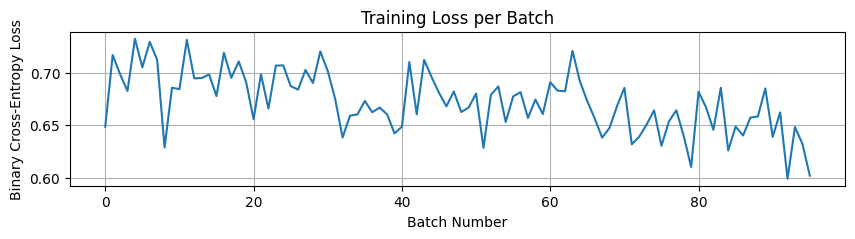

In [ ]:
class TwoTowerModel(nn.Module):
    def __init__(self, user_vocab_sizes, item_vocab_sizes, embed_dim=32):
        super().__init__()

        # User tower embeddings
        self.user_id_emb = nn.Embedding(user_vocab_sizes['user_id'], embed_dim)
        self.rider_type_emb = nn.Embedding(user_vocab_sizes['rider_type'], embed_dim)
        #self.region_emb = nn.Embedding(user_vocab_sizes['region'], embed_dim)

        # Item tower embeddings
        self.loc_id_emb = nn.Embedding(item_vocab_sizes['loc_id'], embed_dim)
        self.loc_cat_emb = nn.Embedding(item_vocab_sizes['loc_cat'], embed_dim)
        #self.pop_bucket_emb = nn.Embedding(item_vocab_sizes['pop_bucket'], embed_dim)

        # MLPs for user and item
        self.user_mlp = nn.Sequential(
            nn.Linear(embed_dim * 2 + 1, 64),
            nn.ReLU(),
            nn.Linear(64, embed_dim)
        )

        self.item_mlp = nn.Sequential(
            nn.Linear(embed_dim * 2 + 1, 64),
            nn.ReLU(),
            nn.Linear(64, embed_dim)
        )

    def forward(self, user_inputs, item_inputs):
        # User tower
        u_emb = torch.cat([
            self.user_id_emb(user_inputs[:, 0]),
            self.rider_type_emb(user_inputs[:, 1]),
            user_inputs[:, 2].unsqueeze(1)  # already normalized
        ], dim=1)


        u_vec = self.user_mlp(u_emb)

        # Item tower
        i_emb = torch.cat([
            self.loc_id_emb(item_inputs[:, 0]),
            self.loc_cat_emb(item_inputs[:, 1]),
            item_inputs[:, 2].unsqueeze(1)
        ], dim=1)
        i_vec = self.item_mlp(i_emb)

        # if we want to add global contextual features
        # can add or even concatenate them to user and input
        # before cosine

        # # Context tower
        # c_emb = torch.cat([
        #     self.time_of_day_emb(context_inputs[:, 0]),
        #     self.day_of_week_emb(context_inputs[:, 1]),
        #     context_inputs[:, 2].unsqueeze(1),  # global_avg_wait_time
        #     context_inputs[:, 3].unsqueeze(1)   # weather_score
        # ], dim=1)
        # c_vec = self.context_mlp(c_emb)
        # sim = F.cosine_similarity(u_vec + c_vec, i_vec + c_vec)

        # Cosine similarity
        sim = F.cosine_similarity(u_vec, i_vec)
        return sim



# Simulated vocab sizes
user_vocab_sizes = {'user_id': 100, 'rider_type': 5, 'mean_days_since_last_logged_in': 15}
item_vocab_sizes = {'loc_id': 200, 'loc_cat': 10, 'mean_distance_to_user' : 5}

# Create simulated data
num_samples = 1000
user_inputs = torch.randint(0, user_vocab_sizes['user_id'], (num_samples, 3))
user_inputs[:, 1] = torch.randint(0, user_vocab_sizes['rider_type'], (num_samples,))
user_inputs[:, 2] = torch.normal(mean=user_vocab_sizes['mean_days_since_last_logged_in'], std=3.0, size=(num_samples,)).clamp(min=0).long()

item_inputs = torch.randint(0, item_vocab_sizes['loc_id'], (num_samples, 3))
item_inputs[:, 1] = torch.randint(0, item_vocab_sizes['loc_cat'], (num_samples,))
item_inputs[:, 2] = torch.normal(mean=item_vocab_sizes['mean_distance_to_user'], std=3.0, size=(num_samples,)).clamp(min=0).long()

# interaction: pos or negative
labels = torch.randint(0, 2, (num_samples,), dtype=torch.float)

# Dataset and dataloader
dataset = TensorDataset(user_inputs, item_inputs, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model, optimizer, loss
model = TwoTowerModel(user_vocab_sizes, item_vocab_sizes)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
# Loss is not normalized in batch
losses = []
for epoch in range(3):
    for user_batch, item_batch, label_batch in dataloader:
        optimizer.zero_grad()
        sim = model(user_batch, item_batch)
        loss = F.binary_cross_entropy_with_logits(sim, label_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

plt.figure(figsize=(10, 2))
plt.plot(losses)
plt.title('Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True)
plt.show()


# Content-based

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

# Movies
movies = pd.DataFrame({
    'movie_id': np.arange(5),
    'genre': ['Action', 'Comedy', 'Drama', 'Action', 'Drama'],
    'duration': [120, 90, 150, 110, 160]
})

# Users
users = pd.DataFrame({
    'user_id': np.arange(2),
    'preferred_genre': ['Action', 'Drama'],
    'preferred_duration': [115, 140]
})

movies

,movie_id,genre,duration
0,0,Action,120
1,1,Comedy,90
2,2,Drama,150
3,3,Action,110
4,4,Drama,160


In [ ]:
users

,user_id,preferred_genre,preferred_duration
0,0,Action,115
1,1,Drama,140


In [ ]:
encoder = OneHotEncoder(sparse_output=False)

# Transform genres
movie_genre_ohe = encoder.fit_transform(movies[['genre']])
user_genre_ohe = encoder.transform(users[['preferred_genre']].rename(columns={'preferred_genre': 'genre'}))

# Calculate cosine similarity

# Combine with duration (normalize to 0-1)
movies_features = np.hstack([
    movie_genre_ohe,
    (movies[['duration']] / 180).values # normalize
])

users_features = np.hstack([
    user_genre_ohe,
    (users[['preferred_duration']] / 180).values
])

movies_features


array([[1.        , 0.        , 0.        , 0.66666667],
       [0.        , 1.        , 0.        , 0.5       ],
       [0.        , 0.        , 1.        , 0.83333333],
       [1.        , 0.        , 0.        , 0.61111111],
       [0.        , 0.        , 1.        , 0.88888889]])

In [ ]:
users_features

array([[1.        , 0.        , 0.        , 0.63888889],
       [0.        , 0.        , 1.        , 0.77777778]])

In [ ]:
# Compute similarity between each user and all movies
similarity = cosine_similarity(users_features, movies_features)

# Recommend top 2 movies for each user
for i, sims in enumerate(similarity):
    top_k = sims.argsort()[::-1][:1]
    print(f"User {i} recommended movie_ids: {movies.iloc[top_k]['movie_id'].tolist()}")


User 0 recommended movie_ids: [0]
User 1 recommended movie_ids: [2]
